In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import lightgbm as lgb

In [2]:
# Display Options of DataFrame
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

In [3]:
# Loading Swap Rate Dataset
swap = pd.read_csv("../Data/market-data-swap-rates.csv")

In [4]:
swap

,Date,Start Date,Tenor,Swap Rate
0,2021-01-13,2022-01-13,10y,1.081333
1,2021-01-13,2022-01-13,15y,1.265960
2,2021-01-13,2022-01-13,18M,0.221625
3,2021-01-13,2022-01-13,1y,0.195474
4,2021-01-13,2022-01-13,2y,0.279370
...,...,...,...,...
63175,2024-01-12,2039-01-12,2y,3.424505
63176,2024-01-12,2039-01-12,3y,3.393758
63177,2024-01-12,2039-01-12,4y,3.358897
63178,2024-01-12,2039-01-12,5y,3.319531


In [5]:
swap = swap.drop_duplicates(['Date', 'Tenor'], keep = 'first') # keep the earliest quoted start date of the swap rate
swap

,Date,Start Date,Tenor,Swap Rate
0,2021-01-13,2022-01-13,10y,1.081333
1,2021-01-13,2022-01-13,15y,1.265960
2,2021-01-13,2022-01-13,18M,0.221625
3,2021-01-13,2022-01-13,1y,0.195474
4,2021-01-13,2022-01-13,2y,0.279370
...,...,...,...,...
63103,2024-01-12,2025-01-13,2y,2.982736
63104,2024-01-12,2025-01-13,3y,2.985417
63105,2024-01-12,2025-01-13,4y,3.009677
63106,2024-01-12,2025-01-13,5y,3.038587


In [6]:
swap.loc[swap['Tenor'].str.endswith("M"), 'Tenor'] = "1.5y"
swap['Tenor'] = swap['Tenor'].str.removesuffix('y')
swap['Tenor'] = swap['Tenor'].astype(float)
swap = swap.drop(columns = "Start Date")

## preprocessing

C:\Users\chanj\AppData\Local\Temp\ipykernel_17440\2701740394.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swap['Tenor'] = swap['Tenor'].str.removesuffix('y')
C:\Users\chanj\AppData\Local\Temp\ipykernel_17440\2701740394.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swap['Tenor'] = swap['Tenor'].astype(float)


In [7]:
swap.reset_index(drop = True, inplace=True)

In [8]:
#Base line model: 2y Tenor
# Subsetting
#swap_2y = swap[swap['Tenor'] == 2]
#swap_2y
subset_1 = swap[swap['Tenor'].isin([2.0, 5.0, 10.0])]
subset_2 = swap[-swap['Tenor'].isin([2.0, 5.0, 10.0])]

In [9]:
target = 'Swap Rate'
y = swap[target]
x = swap['Date'].index

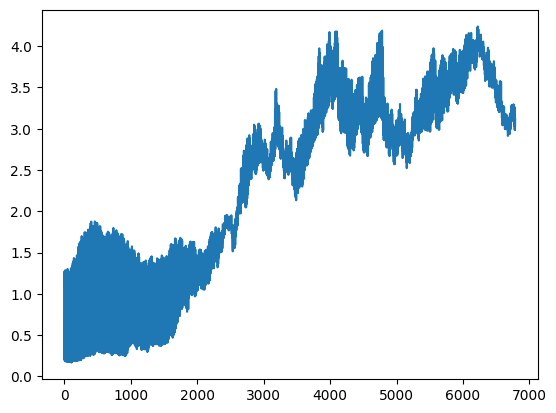

In [10]:
plt.plot(x, y)

In [11]:
y.describe()

count    6786.000000
mean        2.336816
std         1.081411
min         0.167830
25%         1.378390
50%         2.686970
75%         3.184251
max         4.239073
Name: Swap Rate, dtype: float64

In [12]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 6786 entries, 0 to 6785
Series name: Swap Rate
Non-Null Count  Dtype  
--------------  -----  
6786 non-null   float64
dtypes: float64(1)
memory usage: 53.1 KB


In [13]:
# Adding plot title.
#plt.title("Autocorrelation Plot") 
 
# Providing x-axis name.
#plt.xlabel("Lags") 
 
# Plotting the Autocorrelation plot.
#plt.acorr(y, maxlags = 15) 
 
# Displaying the plot.
#print("The Autocorrelation plot for the data is:")
#plt.grid(True)
 
#plt.show() 

In [14]:
# sm.graphics.tsa.plot_pacf(y, lags=20)
# PACF cutoff at lag 1 -> AR(1) process, use lag 1 as lag variable

In [115]:
# Feature Creation
data = swap
delay = data['Tenor'].nunique()
data['Swap Rate Lag 1'] = data.groupby(['Tenor'])['Swap Rate'].shift(1)
data['Swap Rate Moving Average 2'] = data.shift(delay).groupby(['Tenor'])['Swap Rate'].rolling(2).mean().reset_index(0,drop=True)
data['Swap Rate Std 5'] = data.shift(delay).groupby(['Tenor'])['Swap Rate'].rolling(5).std().reset_index(0,drop=True)
data.head(100)

,Date,Tenor,Swap Rate,Swap Rate Lag 1,Swap Rate Moving Average 2,Swap Rate Std 5
0,2021-01-13,10.0,1.081333,NaN,NaN,NaN
1,2021-01-13,15.0,1.265960,NaN,NaN,NaN
2,2021-01-13,1.5,0.221625,NaN,NaN,NaN
3,2021-01-13,1.0,0.195474,NaN,NaN,NaN
4,2021-01-13,2.0,0.279370,NaN,NaN,NaN
5,2021-01-13,3.0,0.404284,NaN,NaN,NaN
6,2021-01-13,4.0,0.536341,NaN,NaN,NaN
7,2021-01-13,5.0,0.664396,NaN,NaN,NaN
8,2021-01-13,8.0,0.950975,NaN,NaN,NaN
9,2021-01-15,10.0,1.089143,1.081333,NaN,NaN


In [116]:
# additional feature engineering process, previous low and high 
# Create a new DF containing day low and day high out of all Tenor of swap rate
CurMin = pd.DataFrame(data.groupby(['Date'])['Swap Rate'].min()).rename(columns= {"Swap Rate": "Min Swap Rate (Cur)"})
CurMax = pd.DataFrame(data.groupby(['Date'])['Swap Rate'].max()).rename(columns= {"Swap Rate": "Max Swap Rate (Cur)"})
CurMinMax = pd.merge(CurMin, CurMax, on = ['Date'])

# Merge back to data
data = data.merge(CurMinMax, on = ['Date'], how = 'left')

# Find Lag Variable (Current is not appropriate for prediction: Lookahead bias)
data['Min Swap Rate (Last)'] = data.groupby(['Tenor'])['Min Swap Rate (Cur)'].shift(1)
data['Max Swap Rate (Last)'] = data.groupby(['Tenor'])['Max Swap Rate (Cur)'].shift(1)

In [117]:
# Drop Cur Max Min data after feature engineering finished
data.drop(columns = ["Min Swap Rate (Cur)", "Max Swap Rate (Cur)"], inplace = True)

In [143]:
features = ['Swap Rate Lag 1', 'Swap Rate Moving Average 2', 'Tenor',  'Swap Rate Std 5']
y = data[target]
X = data[features]

In [144]:
# Split the data into train and test sets
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10
seed = 42
# train is now 75% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state = seed, shuffle=False)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state = seed, shuffle=False) 


In [145]:
# initialize Gradient Boosting model

params = {"n_estimators": 200, 
          "metric": "rmse",        
          "learning_rate": 0.12,           
          "num_leaves": 10,                
          "max_depth": 12,                          
          "early_stopping_round": 4,                         
          "random_state": 42,                         
          "reg_alpha": 0,                          
          "reg_lambda": 1.12,                         
          "min_split_gain": 0.08,                          
          "max_bin": 1000,                         
          "top_rate": 0.2,                        
          "other_rate": 0.1,                         
          "training_metric": True,                       
          "verbose": -1, 
          "force_col_wise": True}
model = lgb.LGBMRegressor(**params)
model.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

# Calculate R^2 and R^2 adj to evaluate model adequacy
y_pred = model.predict(X_test)
R_sq = sklearn.metrics.r2_score(y_test, y_pred)
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1-(1-R_sq)*(n-1)/(n-p-1)
print("R^2 =", R_sq) 
print("Adjusted R^2 =", adjusted_r2)

R^2 = 0.9522567857377046
Adjusted R^2 = 0.9519734432198275


In [147]:
# Quantile Regression Params
params_quant = {
          "objective": 'quantile',
          "n_estimators": 200,        
          "learning_rate": 0.12,           
          "num_leaves": 10,                
          "max_depth": 12,                          
          "early_stopping_round": 4,                         
          "random_state": 42,                         
          "reg_alpha": 0,                          
          "reg_lambda": 1.12,                         
          "min_split_gain": 0.08,                          
          "max_bin": 1000,                         
          "top_rate": 0.2,                        
          "other_rate": 0.1,                         
          "training_metric": True,                       
          "verbose": 1, 
          "force_col_wise": True
}
# CI/2% confidence  = alpha
a = 0.25

In [148]:
# Quantile Regression 
lower = lgb.LGBMRegressor(**params_quant, alpha = a)
lower.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_val, y_val)])
lower_pred = lower.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 3010
[LightGBM] [Info] Number of data points in the train set: 5428, number of used features: 4
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.211554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 4 rounds
Early stopping, best iteration is:
[110]	training's quantile: 0.0179461	valid_1's quantile: 0.0224612


In [149]:
upper = lgb.LGBMRegressor(**params_quant, alpha = 1-a)
upper.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_val, y_val)])
upper_pred = upper.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 3010
[LightGBM] [Info] Number of data points in the train set: 5428, number of used features: 4
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.902354
Training until validation scores don't improve for 4 rounds
Early stopping, best iteration is:
[39]	training's quantile: 0.0341931	valid_1's quantile: 0.0208651


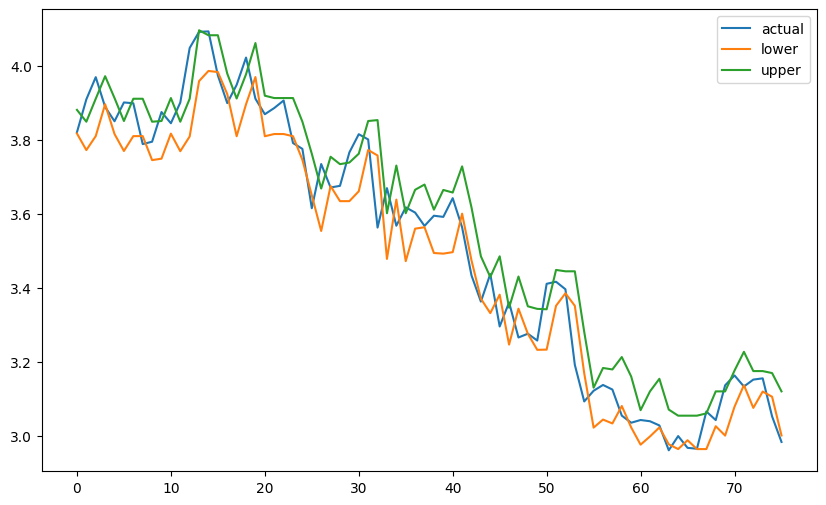

In [150]:
plt.figure(figsize=(10, 6))


y_2y = data[data['Tenor'] == 2.0][target]
X_2y = data[data['Tenor'] == 2.0][features]
X_train, X_2y, y_train, y_2y = train_test_split(X_2y, y_2y, test_size=0.1, random_state = seed, shuffle=False)
y_pred2y = model.predict(X_2y)
y_2y.reset_index(inplace = True, drop = True)
# plot prediction vs actual
plt.plot(y_2y, label='actual')
#plt.plot(y_pred2y, label='prediction')
plt.plot(lower.predict(X_2y), label='lower')
plt.plot(upper.predict(X_2y), label='upper')
# show the legend
plt.legend()
# show the plot
plt.show()

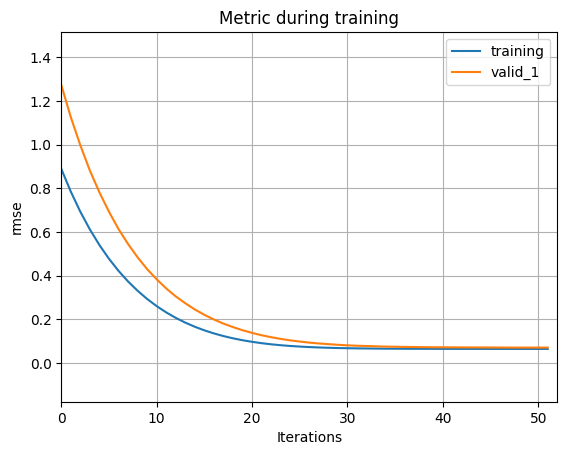

In [151]:
# retrieve performance metrics
lgb.plot_metric(model)
plt.show()

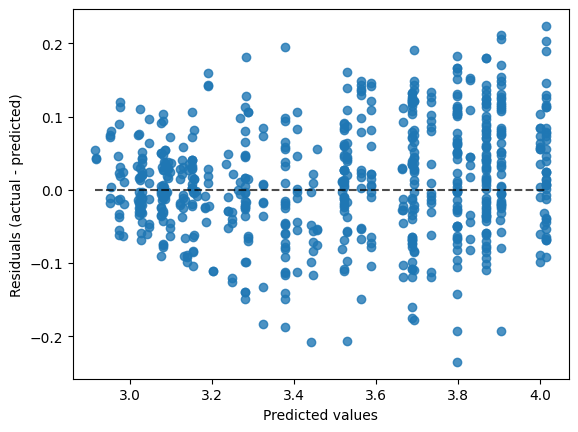

In [152]:
from sklearn.metrics import PredictionErrorDisplay
display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
display.plot()

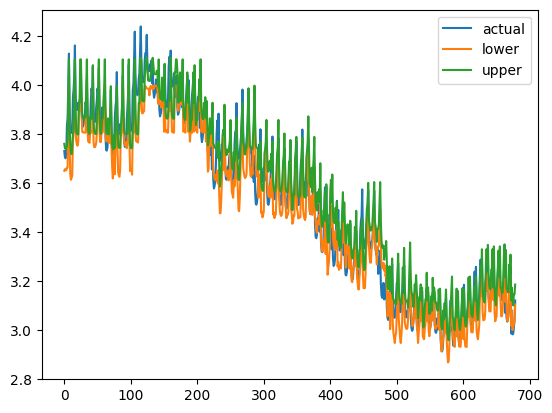

In [153]:
y_test.reset_index(inplace = True, drop = True)
# plot prediction vs actual
plt.plot(y_test, label='actual')
#plt.plot(y_pred, label='prediction')
plt.plot(lower_pred, label='lower')
plt.plot(upper_pred, label='upper')
# show the legend
plt.legend()
# show the plot
plt.show()

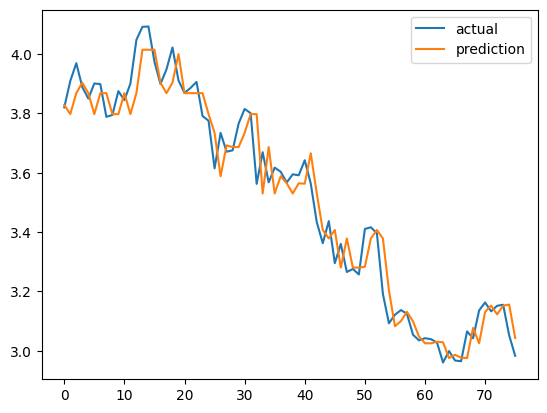

In [154]:
y_2y = data[data['Tenor'] == 2.0][target]
X_2y = data[data['Tenor'] == 2.0][features]
X_train, X_2y, y_train, y_2y = train_test_split(X_2y, y_2y, test_size=0.1, random_state = seed, shuffle=False)
y_pred2y = model.predict(X_2y)
y_2y.reset_index(inplace = True, drop = True)
# plot prediction vs actual
plt.plot(y_2y, label='actual')
plt.plot(y_pred2y, label='prediction')
# show the legend
plt.legend()
# show the plot
plt.show()

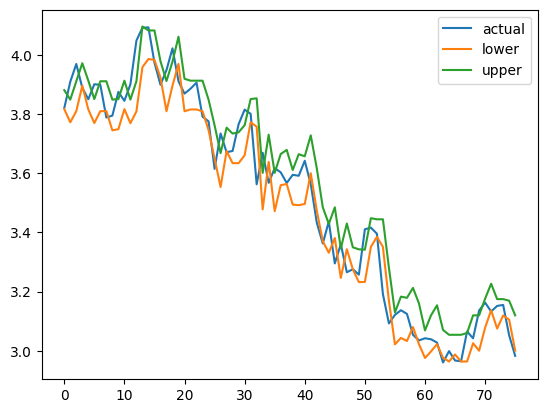

In [155]:
lower_pred = lower.predict(X_2y)
upper_pred = upper.predict(X_2y)
# plot prediction vs actual
plt.plot(y_2y, label='actual')
#plt.plot(y_pred2y, label='prediction')
plt.plot(lower_pred, label='lower')
plt.plot(upper_pred, label='upper')
# show the legend
plt.legend()
# show the plot
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

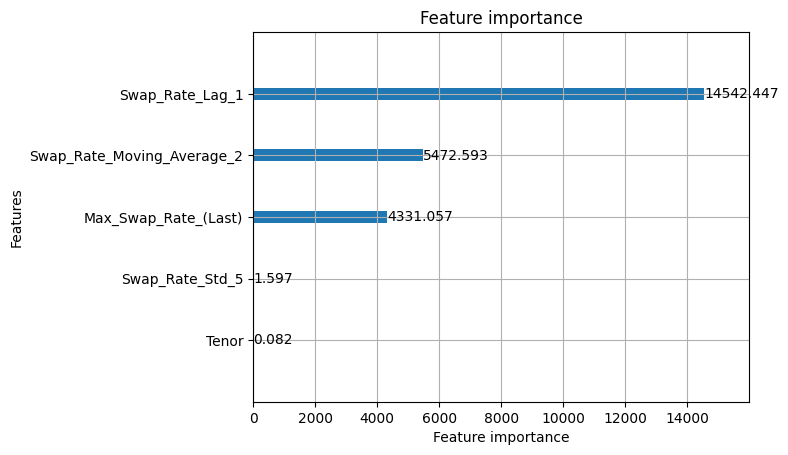

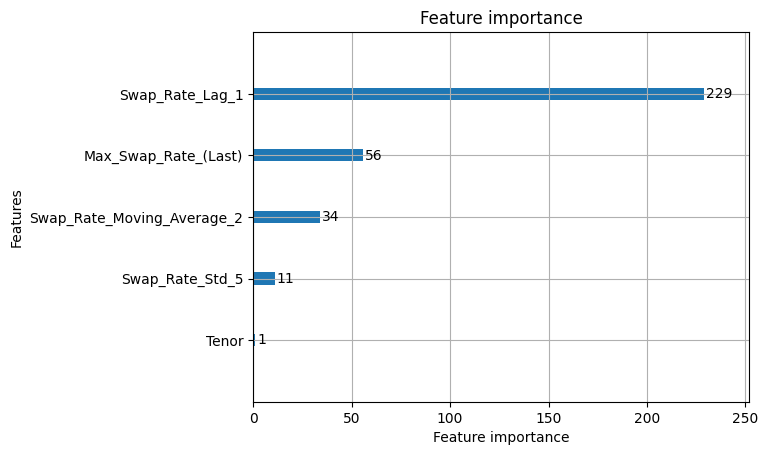

In [131]:
lgb.plot_importance(model, importance_type='gain')
lgb.plot_importance(model, importance_type='split')

In [132]:
# idea, also include prev swap rate spread max and min and median 

In [133]:
#### Alt: Quantile Regression Implementation: Constant error, 
#compute the RMSE value 
error = sklearn.metrics.mean_squared_error(y_pred, y_test) ** 0.5
error


0.07689597272973964

In [134]:
y_upper = y_pred + error
y_lower = y_pred - error

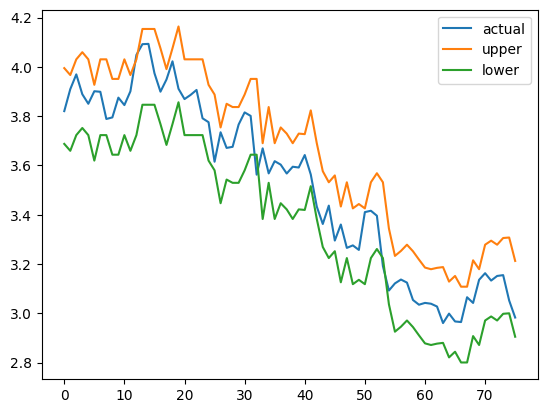

In [137]:
y_2y = data[data['Tenor'] == 2.0][target]
X_2y = data[data['Tenor'] == 2.0][features]
X_train, X_2y, y_train, y_2y = train_test_split(X_2y, y_2y, test_size=0.1, random_state = seed, shuffle=False)
y_pred2y = model.predict(X_2y)
coef = 2
y_2y.reset_index(inplace = True, drop = True)
# plot prediction vs actual
plt.plot(y_2y, label='actual')
#plt.plot(y_pred2y, label='prediction')
plt.plot(y_pred2y + coef* error, label='upper')
plt.plot(y_pred2y - coef*error, label='lower')
# show the legend
plt.legend()
# show the plot
plt.show()

In [138]:
# compute the prediction error vector on the validation set 
validation_error = abs(model.predict(X_val) - y_val)
model_error = abs(model.predict(X_train) - y_train)
model_error 

4       0.355321
13      0.027824
22      0.014232
31      0.020932
40      0.013404
          ...   
6061    0.028581
6070    0.051504
6079    0.020282
6088    0.084059
6097    0.002121
Name: Swap Rate, Length: 678, dtype: float64

In [139]:
error_model = lgb.LGBMRegressor(**params)
error_model.fit(X_train,model_error, eval_set=[(X_train, model_error), (X_val, validation_error)])
# Calculate R^2 and R^2 adj to evaluate model adequacy
error_pred = error_model.predict(X_test)
R_sq = sklearn.metrics.r2_score(abs(model.predict(X_test) - y_test), error_pred)
error_pred

array([0.0564536, 0.0564536, 0.0564536, 0.0564536, 0.0564536, 0.0564536,
       0.0564536, 0.0564536, 0.0564536, 0.0564536, 0.0564536, 0.0564536,
       0.0564536, 0.0564536, 0.0564536, 0.0564536, 0.0564536, 0.0564536,
       0.0564536, 0.0564536, 0.0564536, 0.0564536, 0.0564536, 0.0564536,
       0.0564536, 0.0564536, 0.0564536, 0.0564536, 0.0564536, 0.0564536,
       0.0564536, 0.0564536, 0.0564536, 0.0564536, 0.0564536, 0.0564536,
       0.0564536, 0.0564536, 0.0564536, 0.0564536, 0.0564536, 0.0564536,
       0.0564536, 0.0564536, 0.0564536, 0.0564536, 0.0564536, 0.0564536,
       0.0564536, 0.0564536, 0.0564536, 0.0564536, 0.0564536, 0.0564536,
       0.0564536, 0.0564536, 0.0564536, 0.0564536, 0.0564536, 0.0564536,
       0.0564536, 0.0564536, 0.0564536, 0.0564536, 0.0564536, 0.0564536,
       0.0564536, 0.0564536, 0.0564536, 0.0564536, 0.0564536, 0.0564536,
       0.0564536, 0.0564536, 0.0564536, 0.0564536, 0.0564536, 0.0564536,
       0.0564536, 0.0564536, 0.0564536, 0.0564536, 

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

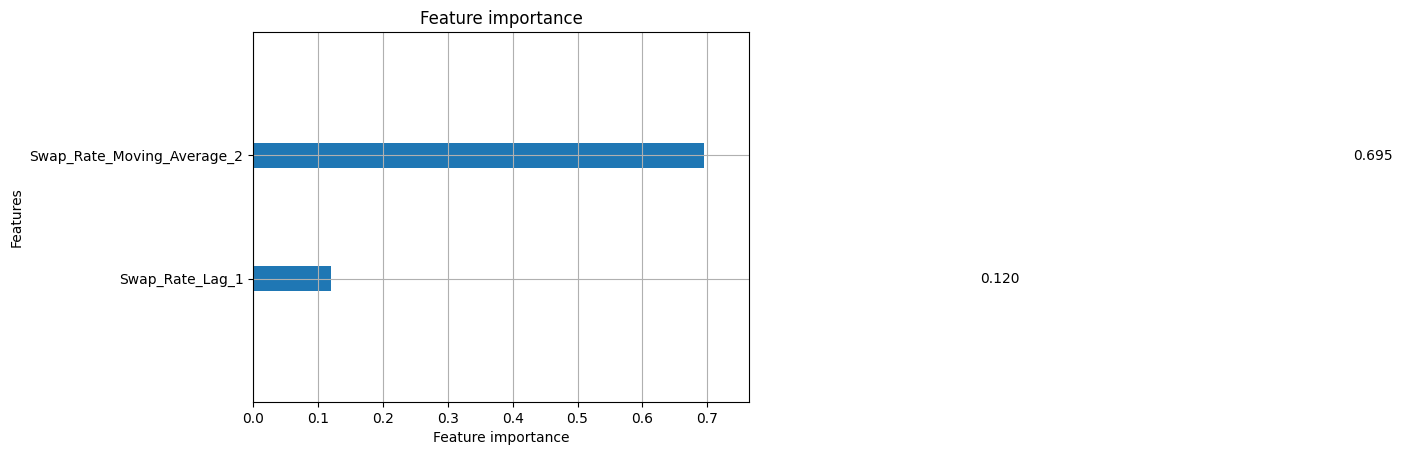

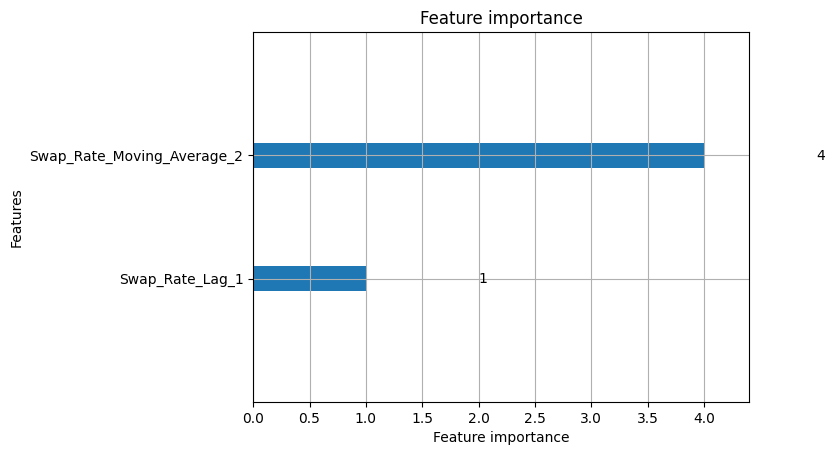

In [140]:
lgb.plot_importance(error_model, importance_type='gain')
lgb.plot_importance(error_model, importance_type='split')

In [141]:
# compute the mean and standard deviation of the distribution 
def Error(X_test):
    std_dev = (error_model.predict(X_test).astype("f8"))
    std_dev = np.nan_to_num(std_dev, copy = False, nan = np.nanmin(std_dev)) # imputation
    return std_dev


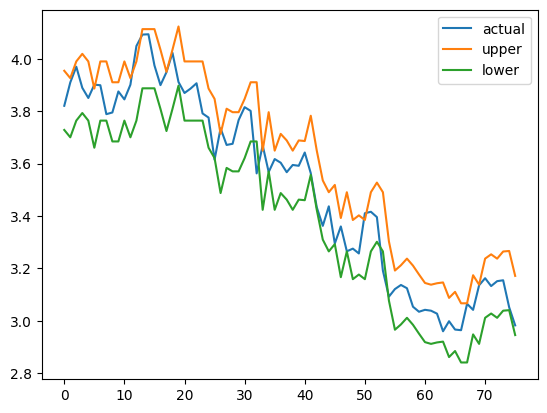

In [142]:
y_2y = data[data['Tenor'] == 2.0][target]
X_2y = data[data['Tenor'] == 2.0][features]
X_train, X_2y, y_train, y_2y = train_test_split(X_2y, y_2y, test_size=0.1, random_state = seed, shuffle=False)
y_pred2y = model.predict(X_2y)
std = Error(X_2y) * 2
y_2y.reset_index(inplace = True, drop = True)
# plot prediction vs actual
plt.plot(y_2y, label='actual')
#plt.plot(y_pred2y, label='prediction')
plt.plot(y_pred2y + std, label='upper')
plt.plot(y_pred2y - std, label='lower')
# show the legend
plt.legend()
# show the plot
plt.show()
# error prediction model is more sensitive to external change than constant variance model

In [ ]:
# TODO: calculate breach ratio of all of 3 method and compare performance

In [188]:
# Breach Ratio: Metrics to evaluate interval estimation efficiency
def breachRatio(lower_model, upper_model, X_test, y_test, alpha):
    lower_bound = lower_model.predict(X_test)
    upper_bound = upper_model.predict(X_test)
    inbound = (y_test > lower_bound) & (y_test < upper_bound)
    total_obs = y_test.count()
    total_inbound = inbound.sum() # all true value will be summed
    actual_confidence = total_inbound/total_obs 
    breach_ratio, sign = abs(actual_confidence - alpha * 2), (actual_confidence - alpha * 2) > 0
    return breach_ratio, sign

In [202]:
breach_ratio, sign = breachRatio(lower, upper, X_test, y_test, a)
print("The breach_ratio of Model is:", breach_ratio, "\nThe prediction interval is", "overbound" if sign else "underbound")

The breach_ratio of Model is: 0.08321060382916051 
The prediction interval is underbound


In [203]:
breach_ratio

0.08321060382916051

In [204]:
sign

False